# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral cloning

### Introduction
The goal of this project is to find a model which predicts steering angles of a driving car based on camera inputs in that way, that the car stays on track. In contrast to the former project the output variable is contineous and therefore it is a regressions problem. Therefore a video game like simulator is provided which allows to generate data by driving (using keyboard and mouse ) two tracks and capturing the resulting video. In addition some data is provided by Udacity. In the following sections I will present my pipeline for this project:


##  Data generation

For the data generation I used the simulator and followed the instructions and tips from Udacity. 
- Track 1:
    - Two full laps in the clockwise and count-clockwise direction
    - Each curve was driven twice (clockwise and count-clockwise)
    - Several recover scenarios were included on straight and curve sections
- Track 2:
    - One lap clockwise, one lap counter-clockwise

During my experimentation I encountered problems with the data I generated. Also I repeated the data generation step several times I was not able to gather the same quality data as the original udacity data set. More details can be found in the section 'The Model'. The following cells use the Udacity data only.
##  Data loading and data cleansing
To load the generated data I created a pandas data frame including all generated csv files. To enhance the data quality I 
reduced the data sets with steering values around zero, since they are overrepresented as one can see from statistics and plots below. This happened in three steps:
1. Removing all data sets with steering values s between -0.1 and 0.1.
2. Calculating the average number of data sets in a bin (using 20 bins).
3. Add back some removed data (3 times the fraction calculated in step 2). 

['D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project3\\TrainingData0\\driving_log.csv']
          Steering     Throttle        Brake        Speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


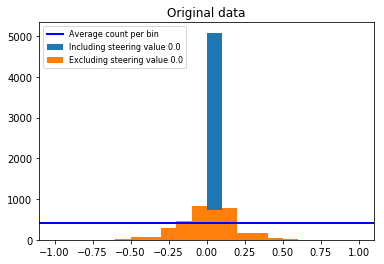

Fraction =  0.06783724463954077
Data entries removed ( -0.1 < steering < 0.1):  5923
Data entries with |steering| > 0.1:  2113
Data entries added back ( -0.1 < steering < 0.1):  1205


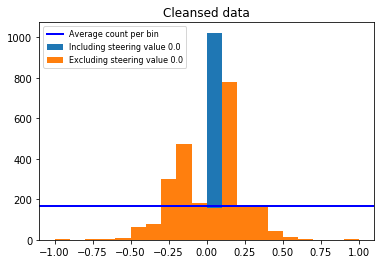

Number of data sets in training data  2654
Number of data sets in validation data  664


In [1]:
import glob
import pandas as pd
import numpy as np
import csv
import cv2
from pandas.io.pytables import IndexCol
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

RandomState = 42

def LoadCSVFiles():
    dataFrame = pd.DataFrame() 
    trainingDataPath =  "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project3/TrainingData*/*.csv"
    
    csvFiles = [file for file in glob.glob(trainingDataPath)]
    print(csvFiles)
    dfList = []
    names = ["Center", "Left", "Right", "Steering", "Throttle", "Brake", "Speed"]
    for file in csvFiles:
        df = pd.read_csv(file, index_col = None, header = None, names = names)  
        dfList.append(df)
    dataFrame = pd.concat(dfList)
    print (dataFrame.describe())
    return dataFrame


def SplitDataInTrainingAndValidationSet(dataFrame):
    #trainingData, validationData = train_test_split(dataFrame, random_state = RandomState, test_size =0.2)
    trainingData, validationData = train_test_split(dataFrame, random_state = RandomState, test_size =0.2)
    return trainingData, validationData  

def DataPreparation(dataFrame, averagePerBin):
    condition = (dataFrame['Steering'] < 0.1) & ( dataFrame['Steering'] > -0.1)
    dataFrameZeroAngle = dataFrame[condition]
    fraction = averagePerBin/len(dataFrameZeroAngle) 
    print("Fraction = ", fraction)
    print ("Data entries removed ( -0.1 < steering < 0.1): ", len(dataFrameZeroAngle))
    dataFrameCleansed= dataFrame[~condition]
    print ("Data entries with |steering| > 0.1: ", len(dataFrameCleansed))    
    dataFrameZeroAngle = dataFrameZeroAngle.sample(frac=3*fraction,random_state = RandomState+3)
    print ("Data entries added back ( -0.1 < steering < 0.1): ", len(dataFrameZeroAngle))
    newDataFrame = pd.concat([dataFrameCleansed, dataFrameZeroAngle]) 
    newDataFrame = newDataFrame.sample(frac =1.0, random_state = RandomState+2)
    return newDataFrame

def DataVisualization(labels, title):
    binNumber = 20
    plt.hist(labels, bins=binNumber, range = (-1, 1), label = "Including steering value 0.0")
    cleanedLabels = list(filter(lambda a: a != 0.0, labels))
    plt.hist(cleanedLabels, bins=binNumber, range = (-1, 1), label = "Excluding steering value 0.0")
    averagePerBin = len(labels)/binNumber
    plt.axhline(y= averagePerBin, xmin=-1, xmax=1, linewidth=2, color = 'b', label = "Average count per bin")
    plt.legend(loc='upper left', prop={'size': 8})
    plt.title(title)
    plt.show()
    return averagePerBin

    
csvData = LoadCSVFiles()
averagePerBin = DataVisualization(csvData['Steering'].tolist(), "Original data")
csvData = DataPreparation(csvData, averagePerBin)
DataVisualization(csvData['Steering'].tolist(), "Cleansed data")
trainingData, validationData = SplitDataInTrainingAndValidationSet(csvData)
print("Number of data sets in training data ", len(trainingData))
print("Number of data sets in validation data ", len(validationData))

 

##  Data generator, data augmentation, data preprocessing
I implemented the data generator as advised and required by the project description.  
For data augmentation I included the follwoing steps inspired by the former project (Traffic sign classifier), Udacity project description, the [Nvidia paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and this [link](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9).:
- Random choice of camera. For images from the left/right camera the steering angle was corrected by +/- 0.25.
- Random shift of the picture in vertical/horizontal direction.
- Randomize the orientation of the image (original or vertical flip) which allows the 
- Randomize the brightness of the image
- Add random shadows to the image

After the augmentation each image was preprocessd. Follwoing the [Nvidia paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) I implemented 
- Cropping the image, by removing the horizon and the car front (new size: 90x320)
- Resizing the image to 66x200 pixels
- Converting the image to YUV color space
- Normalize the image 

In [6]:
'''
Data generator which yields the batches we need
'''
def DataGenerator(data, model, batchSize = 128):
    dataSize = len(data)
    images = []
    angles = []
    countZeroAngles = 0
    while True: # Loop forever so the generator never terminates
        while( len(images) < batchSize):
            sample = data.iloc[np.random.randint(dataSize-1), :]
            
            augmentedImage, augmentedAngle = DataAugmentation(sample)
            preprocessedImage = ImagePreprocessing(augmentedImage, model)
            images.append(preprocessedImage)
            angles.append(augmentedAngle)

            #cv2.imshow('frame',preprocessedImage)
            #if cv2.waitKey(1000) & 0xFF == ord('q'):
            #    x =1

        features = np.array(images)
        labels = np.array(angles)
        assert (len(features) == len(labels)  )
        
        yield sklearn.utils.shuffle(features, labels, random_state = RandomState+1)

        
        
    
def RandomCamera(sample):
    centerLeftRight = ['Center', 'Left', 'Right']
    camera = centerLeftRight[np.random.randint(0,3)]
    
    path = sample[camera]
    #print(path)
    image = cv2.imread(path)
    angleCorrection = 0.25
    angle = sample['Steering']
    if(camera == 'Left'):
        angle += angleCorrection
    elif(camera == 'Right'):
        angle -= angleCorrection

    return image, angle

def RandomizeBrightness(image):
    hsvImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Use float value
    imageFloat = np.array(hsvImage, dtype = np.float64)
    randomBrightness = 0.5+np.random.uniform()
    imageFloat[:,:,2] = imageFloat[:,:,2]*randomBrightness
    imageFloat[:,:,2][imageFloat[:,:,2]>255]  = 255
    newImage = np.array(imageFloat, dtype = np.uint8)
    newImage = cv2.cvtColor(newImage,cv2.COLOR_HSV2BGR)
    return newImage


def RandomShift(image,angle,translationMax):
    widthTranslation = translationMax*np.random.uniform()-translationMax/2.0
    adjustedAngle = angle + widthTranslation/translationMax*2*.2
    heightTranslation = 40*np.random.uniform()-40/2
    
    translationMatrix = np.float32([[1,0,widthTranslation],[0,1,heightTranslation]])
    translatedImage = cv2.warpAffine(image,translationMatrix,(image.shape[1],image.shape[0]))

    return translatedImage, adjustedAngle


def RandomFlip(image, angle):
    flip = np.random.choice(2)

    if(flip):
        image = cv2.flip(image,1)
        angle = -angle
    
    return image, angle


def AddRandomShadow(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    left = 320*np.random.uniform()
    top = 0
    bottom = 160
    right = 320*np.random.uniform()
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    
    shadowMask = 0*image[:,:,0]
    shadowMask[((X_m-top)*(right-left) -(bottom - top)*(Y_m-left) >=0)]=1

    if np.random.randint(2)==1:
        random_bright = .5
        condition1 = shadowMask==1
        condition2 = shadowMask==0
        if np.random.randint(2)==1:
            image[:,:,0][condition1] = image[:,:,0][condition1]*random_bright
        else:
            image[:,:,0][condition2] = image[:,:,0][condition2]*random_bright    

     
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    return image

def ImagePreprocessing(inputImage, model):
    imageHeight = inputImage.shape[0] 
    imageWidth = inputImage.shape[1]
    newImage = inputImage[50:140,:]
    
    if(model[:-1] == "Nvidia"):
        newImage = cv2.resize(newImage,(200,66), interpolation = cv2.INTER_AREA)
    elif(model == "Other"):
        newImage = cv2.resize(newImage,(32,32), interpolation = cv2.INTER_AREA)
    
    newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2YUV)    
    newImage = newImage/127.5 - 1.0
    
    return newImage

def DataAugmentation(sample):
    image, angle = RandomCamera(sample)
    flippedImage, flippedAngle = RandomFlip(image, angle)

    translationMax = 100.0
    shiftedImage, shiftedAngle = RandomShift(flippedImage, flippedAngle, translationMax)
    brightedImage = RandomizeBrightness(shiftedImage)
    imageWithShadows = AddRandomShadow(brightedImage)

    return imageWithShadows, shiftedAngle 

Model = 'Nvidia1'
trainingGenerator = DataGenerator(trainingData, Model, batchSize =128)
validationGenerator = DataGenerator(validationData, Model, batchSize =128)


## The model
I started with the classic Nvidia model described in [Nvidia paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) but found that this model overfits severly. To improve the model performance I tried the following modifications:
- Added different activation function
    1. Relu
    2. Elu
- Adding dropouts to the
    1. convolutional layers
    2. fully connected layers
    3. both of the above
- Adjusted the filtersize of the convolutional layers
- Adjusted the stride size in the convolutional layers
- Added l2 weight regularization
    1. convolutional layers
    2. fully connected layers
    3. both of the above
- Removed convolutional layers and added max pooling layers

In sum I experimented with over 50 models but the most succesfull results drove only half a lap without problems. Since none of the models worked I removed old data and added new one (in sum over 2 Gigabytes of images) and experimented further. I found that the validation loss is not a good measure. Promising models with low training loss (~0.02) and low validation loss (~0.04) failed when tested in autonomous mode. After a hint from my mentor I removed all data generated by myself and used only the Udacity data. With this setup I found a model which completed track1 without any error. In a subsequent study I tried to reduce the number of parameters and found the final model below. Although the back and forth of the validation loss indicates overfitting, the model works fine on the track1. 
   

In [7]:
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
from keras.utils.visualize_util import plot
import keras


def TheWorkingNvidiaMod(trainingGenerator, validationGenerator):
    print ("The first modified Nvidia model")
    print("Keras Version: ", keras.__version__)
    dropoutRate = 0.5
    Model = Sequential()
    
    Model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', input_shape=(66,200,3)))
    Model.add(Activation('relu'))
    Model.add(Dropout(dropoutRate))
    
    Model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid' ))
    Model.add(Activation('relu'))
    Model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid' ))
    Model.add(Activation('relu'))
    Model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='same'))
    Model.add(Activation('relu'))
    Model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
    Model.add(Activation('relu'))
    
    Model.add(Flatten())
    
    Model.add(Dense(100))
    
    Model.add(Dense(10))
    
    Model.add(Dense(1))
    
    plot(Model, to_file="model.png",show_shapes=True)
    
    print(Model.summary())
    
    Model.compile(optimizer =Adam(lr = 0.0001), loss= 'mse')
    
    history = Model.fit_generator(trainingGenerator, validation_data=validationGenerator, nb_val_samples=2560, samples_per_epoch=20480, nb_epoch=10, verbose=2)
    
    Model.save('./model.h5')
    

TheWorkingNvidiaMod(trainingGenerator, validationGenerator)

The first modified Nvidia model
Keras Version:  1.2.1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 31, 98, 24)    0           activation_6[0][0]               
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       dropout_2[0][0]                  
_____________________________________

## Summary and outlook
This project teached me quite a lesson and the lesson is not over yet. I investigated quite a few models and found that the usual quality measures (e.g. validation loss) do not always indicate the performance of a model. In addition the quality of the data for learning is essential. I have not yet figured out why all my careful generated data provided such 'bad' learning material. In addition I want to investigate how to succeed on track 2 without training on it. 